# Impact Function Calibration

Here is a walkthrough of the NCCS calibration module.

The structure and naming mirrors the CLIMADA calibration module, but this addds flexibility and functionality to calibrate entire model pipelines and heterogeneous observations.


In [17]:
# Import
import sys
sys.path.append('../..')
import logging
import climada
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import copy
import os
import pycountry
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_log_error
from climada.util import log_level
from climada.entity import ImpactFuncSet, ImpfTropCyclone

from calibration.base import NCCSInput
from calibration.bayesian_optimizer import NCCSBayesianOptimizer, NCCSBayesianOptimizerController
from calibration.rp_errors import rp_rmse
from utils import folder_naming

logging.getLogger("climada").setLevel("INFO")
warnings.filterwarnings("ignore", category=DeprecationWarning)

LOGGER = logging.getLogger(__name__)

## User-supplied components of an NCCS calibration

The input to an NCCS calibration looks like this:

```
input = NCCSInput(
    config = config_template,
    data = obs,
    write_impact_functions = write_regional_tc_impact_function,
    return_period_impacts_from_config = return_period_impacts_from_config,
    cost_func = rp_rmse,
    bounds = bounds,
    constraints = constraints,
    linear_param='scale'
)
```

We'll go through these components one by one

### 1. Config template

A calibration will run the modelling pipeline many times, each time sampling from the parameter space we're exploring and optimising, each time giving different impact functions.

The `config_template` describes the model pipeline that will be run each time. The code will update the run's name each time the model is called so taht outputs are stored separately.

The impact functions themselves are _not_ contained in the config file. The `"calibrated": "custom"` entry says that impact functions should be read from a file, which the calibration will provide each time the model is called.

MS: I use the RF label for river flood, 2q to signalise dividing events into 2 quantile cuts and 0 to denote 0-zth quantile being used.

In [18]:
# NCCS model config

import pathos as pa
ncpus = 3
ncpus = pa.helpers.cpu_count() - 2

project_folder = "calibration_v1/RF/2q0/"

config_template = {
    "run_title": project_folder + "RF_2q0_",
    "n_sim_years": 0,                   # (We don't do this part of the pipeline)
    "io_approach": [],                  # (We don't do this part of the pipeline)
    "force_recalculation": False,
    "use_s3": False,
    "log_level": "INFO",
    "seed": 161,

    # Which parts of the model chain to run:
    "do_direct": True,                  # Calculate direct impacts (that aren't already calculated)
    "do_yearsets": False,               # Calculate direct impact yearsets (that aren't already calculated)
    "do_multihazard": False,            # Also combine hazards to create multi-hazard supply chain shocks
    "do_indirect": False,               # Calculate any indirect supply chain impacts (that aren't already calculated)

    # Impact functions:
    "business_interruption": False,     # Turn off to assume % asset loss = % production loss. Mostly for debugging and reproducibility
    "calibrated": "custom",             # Custom impacts

    # Parallisation:
    "do_parallel": True,                # Parallelise some operations
    "ncpus": ncpus,

    "runs": [
        {
            "hazard": "river_flood",
            "io_approach": [],
            "sectors": ["economic_assets"],
            "countries": None,   # We'll set these in a moment
            "scenario_years": [
                {"scenario": "None", "ref_year": "historical"},
            ],
        },
    ]
}

## 2. Observation data

The observations are prepared by scripts in the resources/calibration_calculations/observations_calculations/ folder and stored in the resources/calibration_calculations/observations_calculations/ folder.

For TCs all observations are currently of the form region - country - event_id - return period - impact (USD), extracted from EM-DAT.

The calibration of the impact functions will compare modelled return period losses to the these observations.

This calibration is for the Southern Indian ocean `SI` region because it's computationally quite cheap.

In [19]:
# Load observations

obs = pd.read_csv("../../resources/observations/data/rf.csv")
vuln_country_data= pd.read_csv("../../resources/vuln_2022_nd_gain.csv")
vuln_quantiles_split = 2
#Fill in values for small countries which have no vulnerabilities but do have flood events
#AND, LIE, MCO, KNA, SMR
#AND and MCO get France

vuln_country_data.loc[vuln_country_data["country"]=="AND", "vuln_nd_gain_2022"]=vuln_country_data.loc[vuln_country_data["country"]=="FRA", "vuln_nd_gain_2022"].iloc[0]
vuln_country_data.loc[vuln_country_data["country"]=="MCO", "vuln_nd_gain_2022"]=vuln_country_data.loc[vuln_country_data["country"]=="FRA", "vuln_nd_gain_2022"].iloc[0]
#LIE gets switzerland
vuln_country_data.loc[vuln_country_data["country"]=="LIE", "vuln_nd_gain_2022"]=vuln_country_data.loc[vuln_country_data["country"]=="CHE", "vuln_nd_gain_2022"].iloc[0]
#SMR gets italy
vuln_country_data.loc[vuln_country_data["country"]=="SMR", "vuln_nd_gain_2022"]=vuln_country_data.loc[vuln_country_data["country"]=="ITA", "vuln_nd_gain_2022"].iloc[0]
#KNA gets DMA
vuln_country_data.loc[vuln_country_data["country"]=="KNA", "vuln_nd_gain_2022"]=vuln_country_data.loc[vuln_country_data["country"]=="DMA", "vuln_nd_gain_2022"].iloc[0]


vuln_country_data["vuln_quantile"]=pd.qcut(vuln_country_data['vuln_nd_gain_2022'], vuln_quantiles_split, labels=False)
obs = obs.merge(vuln_country_data, on="country", how="left")

obs = obs[(obs["vuln_quantile"] == 0)]
countries_iso3alpha = obs['country'].unique().tolist()
#Drop countries not existing anymore
countries_remove = ["DFR", "SPI", "SUN", "YUG"]
countries_iso3alpha = [country for country in countries_iso3alpha if country not in countries_remove]


countries = [pycountry.countries.get(alpha_3=c).name for c in countries_iso3alpha]
n_years =max(obs['rp'])

# Set the run's countries to these
config_template['runs'][0]['countries'] = countries

obs

,country,year,rp,impact,vuln_nd_gain_2022,vuln_quantile
3,ALB,2002,34.000000,28472.0,0.386332,0.0
4,ALB,2004,17.000000,268.0,0.386332,0.0
5,ARG,1993,34.000000,2212258.0,0.371704,0.0
6,ARG,1998,17.000000,1974870.0,0.371704,0.0
7,ARG,2003,11.333333,1635754.0,0.371704,0.0
...,...,...,...,...,...,...
825,ZAF,2021,4.250000,81002.0,0.383277,0.0
826,ZAF,2019,3.777778,57236.0,0.383277,0.0
827,ZAF,1996,3.400000,12800.0,0.383277,0.0
828,ZAF,1999,3.090909,11068.0,0.383277,0.0


# 3. `write_impact_functions`: a method to write custom impact functions from sampled input parameters

This is the model pipeline setup stage. Any changes to the model inputs and pipeline before it's run are made here, based on the sampled parameters for this run of the model. 

Currently this means writing impact functions defined by the input parameters to a file that is read in during the impact calculations.

In [20]:
from calibration.utils import write_exp_impf_to_file

def write_regional_rf_impact_function(v_half):
    write_exp_impf_to_file('river_flood', v_half)

## 4. `return_period_impacts_from_config`: a method to reproduce the observations with the model

This is the most complex part of the setup.

Given the observations that we have (and given that they might be very heterogeneous: a bunch of summary statistics gathered from the literature), we need a method that runs the NCCS modelling pipeline and then reads in the results to recreate the observations.

The output of this method will be used as input to the following `cost_func` cost function, which we also supply (so there is some flexibility).

The method below takes a config file (the optimizer takes the config template and generates a new config for each iteration). It runs the model pipeline and then reads the output, calculating return period losses by country to match the observations we have.

In [21]:
# We need this method in other places too: go check it out, it's at the core of the calibration
from calibration.utils import return_period_impacts_from_config
from analysis import run_pipeline_from_config
from pipeline.direct.direct import HAZ_N_YEARS
from climada.engine import Impact

# MS: no changes here

## 5. The cost function

This is a method that takes two dataframes: the observations and the observations as reproduced by the model. It aligns them and calculates some measure of the 'difference' between them (a 0 is a perfect reproduction, and higher values mean the model is worse. Note this is different from optimizations that want to maximize the objective function: the code accounts for this).

In this case we use the root mean square error which is provided by a util function in `calibration.rp_errors`.

There are three decisions/assumptions worth noting in this choice of cost function:
- we use the root mean square error to evaluate model performance (not the log). This means that error from small events aren't very important and errors from large events dominate the cost function. This is what we want. (Other options to consider: root_mean_squared_log_error, mean_squared_error)
- all return periods are weighted equally. If we want to weight towards more extreme events we can reconsider this
- all events are weighted equally. That means that countries with more events (and therefore more observations) have a stronger effect on the calibration

In [22]:
cost_function = rp_rmse

## 6. The input parameter bounds

These provide a permitted range for each parameter we're working with. It's a dictionary giving bounds for each parameter.

MS: I assumed that half dame of flood makes sense between at 10cm and 3m for commercial buildings. 

In [24]:
# bounds = {"v_thresh": (25.8, 25.8), "v_half": (25.8, 150), "scale": (0.01, 1)}
bounds = {"v_half": (0.1, 3.0)}

Later we will also need code to visualise the input parameters. In this case the parameters correspond directly to a single impact function, though this won't always be the case.

In [25]:
#from climada.entity import ImpfTropCyclone
from calibration.version1.rf_calibration import ImpfFlood

def impf_from_params(params):
    return ImpfFlood.from_exp_sigmoid(v_half=params['v_half'], intensity=np.arange(0.0, 12.0, 0.1))

The 'default' impact function that we're improving on is this:

MS: I took the Africa one as example from climada_petals ImpfRiverFlood. Based on the literature those functions are for residential areas, I expect for commercial production damage happens faster than for residential areas.

<Axes: title={'center': 'RF 1: Flood Africa JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>

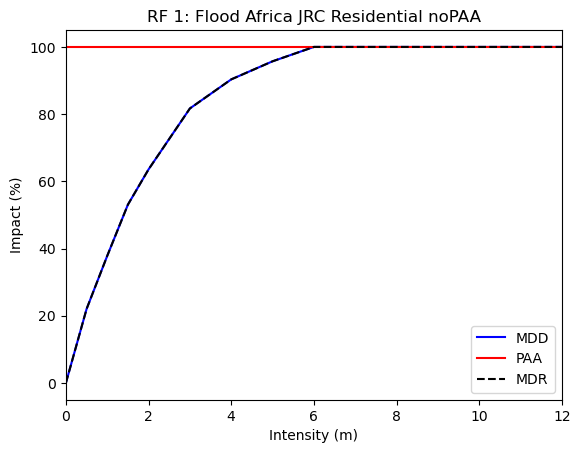

In [26]:
from pipeline.direct.direct import get_impf_tc
from climada.entity import ImpfSetTropCyclone
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood
default_impf = ImpfRiverFlood.from_region(region='africa')
default_impf.plot()


# default_impf = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()
# default_impf = default_impf.get_func(haz_type='TC', fun_id=5)  # 1: NA1, 5: SI
# default_impf.plot()

And the parameter space we're searching is huge. We can sample it:

MS: Here one can see that the single parametric space of exp sigmoids covers the for example Africa curve very nicely. I took it as an example because as noted commercial exposures should be more vulnerable than residential.

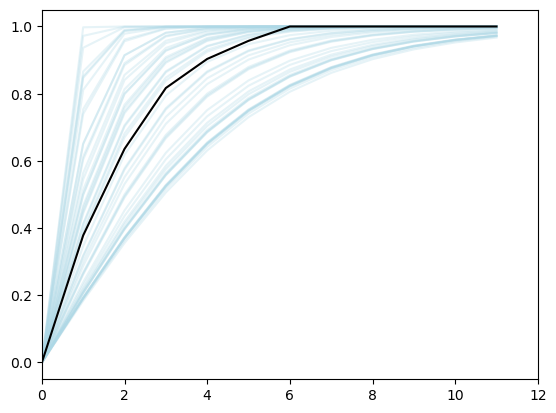

In [31]:
fig, ax = plt.subplots()

n_samples = 50
v_half_samples = np.random.uniform(*bounds['v_half'], size=n_samples)

for i in range(n_samples):
    v_half = v_half_samples[i]
    impf = impf_from_params({'v_half': v_half})
    ax.plot(
        np.arange(0,12),
        impf.calc_mdr(np.arange(0,12)),
        color='lightblue',
        alpha=0.3
    )

ax.plot(
    np.arange(0,12),
    default_impf.calc_mdr(np.arange(0,12)),
    color='black',
)

ax.set_xlim([0.0, 12.0])

plt.show()


# Constraints

The BayesianOptimization also takes `constraints`. These can also be provided here. There are no constraints in this run.

When we apply constraints later we'll do it in a strangely crude way where we code them ourselves and  return a really bad result that the cost function will hate. Seems like a weird approach but it's recommended here: https://bayesian-optimization.github.io/BayesianOptimization/1.5.1/constraints.html#1.-Simple-Constrained-Optimization

In [28]:
constraints = None

# Linear parameter

The `linear_param` parameter is new to the NCCS calibration.

If you know that the impacts in the data frame produced by the `return_period_impacts_from_config` method are linear in one of the input parameters, specify that here.

For most impact functions that we'll look at in NCCS there will be a `scale` parameter which provides a linear scaling to the impacts. So we specify this here.

The modelling pipeline is set up to recognise that adjustments to this parameter are extremely cheap and so it samples generously when this is the case.

# Run the calibration

Now we can put this all together!

MS: In this section it fails to generate the dataframe with results from the pipeline run :/ Seems something to fix in the pipeline.

In [30]:
from climada.util import log_level

logging.getLogger('calibration').setLevel(logging.DEBUG)


# Define calibration input
with log_level("WARNING", name_prefix="climada"):
    with log_level("INFO", name_prefix="climada.util.calibrate"):
        input = NCCSInput(
            config = config_template,
            data = obs,
            write_impact_functions = write_regional_rf_impact_function,
            return_period_impacts_from_config = return_period_impacts_from_config,
            cost_func = cost_function,
            bounds = bounds,
            constraints = constraints,
            #linear_param='scale'
            # results_file='SI_results.csv'
        )

        # Create and run the optimizer
        opt = NCCSBayesianOptimizer(input)
        controller = NCCSBayesianOptimizerController.from_input(input)
        bayes_output = opt.run(controller)
        bayes_output.params  # The optimal parameters

2024-10-15 10:26:21,367 - calibration.base - DEBUG - Creating the NCCSInput object
2024-10-15 10:26:21,368 - calibration.bayesian_optimizer - DEBUG - Initialising the NCCSBayesianOptimizer
2024-10-15 10:26:21,369 - calibration.base - DEBUG - Initialising an NCCSOptimizer without a cache
2024-10-15 10:26:21,369 - calibration.bayesian_optimizer - DEBUG - Initialising the NCCSBayesianOptimization
2024-10-15 10:26:21,370 - calibration.bayesian_optimizer - DEBUG - Starting the execution of the NCCSBayesianOptimizer
2024-10-15 10:26:21,371 - calibration.bayesian_optimizer - INFO - Gathering any data saved from previous runs in /Users/marcelserina/Dev/nccs-supply-chain/results/calibration_v1/RF/2q0
2024-10-15 10:26:21,372 - calibration.bayesian_optimizer - INFO - RF_2q0_fb58f550: Found a folder set up for parameters {'v_half': 1.251066014107722}. Adding to the queue.
2024-10-15 10:26:21,372 - calibration.bayesian_optimizer - DEBUG - Adding params to queue (probe method): {'v_half': 1.25106601

ValueError: No impacts found

In [15]:
output_dir = Path(folder_naming.get_direct_output_dir(config_template['run_title'])).parent.parent
calibration_output_path = Path(output_dir, 'optimisation_output.hdf5')

In [16]:
# Save output to file
bayes_output.to_hdf5(calibration_output_path)

In [9]:
# Upload the output to S3
from utils.s3client import upload_project_folder_to_s3
upload_project_folder_to_s3(project_folder)

In [17]:
# Read output from file
from calibration.bayesian_optimizer import NCCSBayesianOptimizerOutput
bayes_output = NCCSBayesianOptimizerOutput.from_hdf5(calibration_output_path)

/opt/homebrew/Caskroom/miniforge/base/envs/nccs/lib/python3.9/site-packages/climada/util/calibrate/bayesian_optimizer.py:193: UserWarning: 
Data point [  0.42285178 115.26709884] is outside the bounds of the parameter space. 
  p_space.register(
/opt/homebrew/Caskroom/miniforge/base/envs/nccs/lib/python3.9/site-packages/climada/util/calibrate/bayesian_optimizer.py:193: UserWarning: 
Data point [  0.32385178 115.26709884] is outside the bounds of the parameter space. 
  p_space.register(
/opt/homebrew/Caskroom/miniforge/base/envs/nccs/lib/python3.9/site-packages/climada/util/calibrate/bayesian_optimizer.py:193: UserWarning: 
Data point [  0.37335178 115.26709884] is outside the bounds of the parameter space. 
  p_space.register(
/opt/homebrew/Caskroom/miniforge/base/envs/nccs/lib/python3.9/site-packages/climada/util/calibrate/bayesian_optimizer.py:193: UserWarning: 
Data point [  0.40305178 115.26709884] is outside the bounds of the parameter space. 
  p_space.register(
/opt/homebrew/Ca

## Evaluate Output

The Bayesian Optimizer returns the entire paramter space it sampled and we can investigate the cost function's behaviour within this space.

Here we print the samples examined by the optimizer. Notice that the optimal parameter set is not necessarily the last entry in the parameter space!

In [18]:
p_space_df = bayes_output.p_space_to_dataframe()
p_space_df

Parameters               Calibration
               scale      v_half Cost Function
Iteration                                     
0           0.422852  115.267099  3.441414e+08
1           0.323852  115.267099  3.447756e+08
2           0.373352  115.267099  3.444585e+08
3           0.403052  115.267099  3.442682e+08
4           0.442652  115.267099  3.440146e+08
...              ...         ...           ...
333         0.021453   30.664971  2.633319e+08
334         0.051153   30.664971  1.696129e+08
335         0.090753   30.664971  1.697643e+08
336         0.120453   30.664971  2.635757e+08
337         0.169953   30.664971  4.632336e+08

[338 rows x 3 columns]

In contrast, the controller only tracks the consecutive improvements of the best guess:

In [19]:
controller.improvements()

,iteration,random,target,improvement
sample,,,,
0,0,True,-3.435076e+08,inf
1,0,True,-3.381892e+08,0.015726
2,0,True,-1.909415e+08,0.771166
13,0,True,-1.458813e+08,0.308883
16,0,False,-1.454323e+08,0.003087
17,0,False,-1.452349e+08,0.001359
19,0,False,-1.450928e+08,0.000979
20,0,False,-1.450247e+08,0.000469


Notice that the optimal parameter set is not necessarily the last entry in the parameter space!
Therefore, let's order the parameter space by the ascending cost function values.

In [20]:
p_space_df = p_space_df.sort_values(("Calibration", "Cost Function"), ascending=True)
p_space_df

Parameters              Calibration
               scale     v_half Cost Function
Iteration                                    
129         0.070827  30.658874  1.450247e+08
123         0.070655  30.663197  1.450928e+08
332         0.070953  30.664971  1.451147e+08
326         0.070954  30.665015  1.451154e+08
320         0.070954  30.665062  1.451161e+08
...              ...        ...           ...
203         0.476857  32.437094  1.361319e+09
200         0.496657  32.437094  1.429527e+09
204         0.516457  32.437094  1.497784e+09
205         0.546157  32.437094  1.600239e+09
206         0.595657  32.437094  1.771154e+09

[338 rows x 3 columns]

We can then plot the cost function within the parameter space:

[<Axes: title={'center': 'Cost function within parameter space (log colour scale)'}, xlabel='(Parameters, scale)', ylabel='(Parameters, v_half)'>]

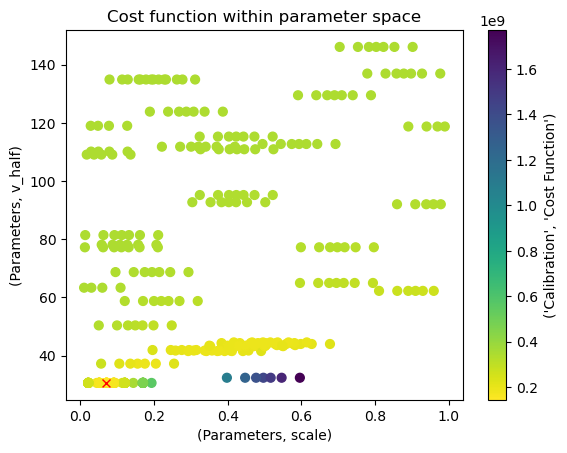

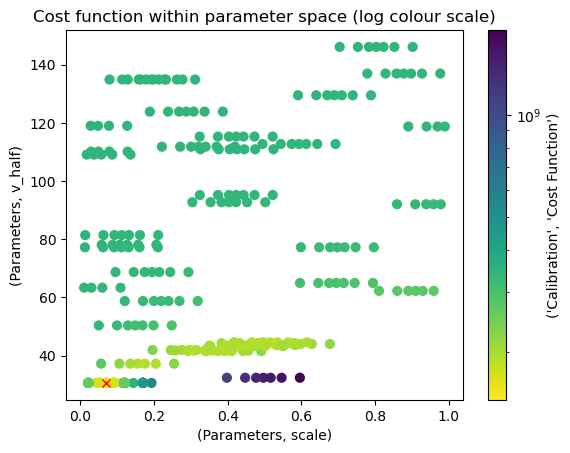

In [21]:
import matplotlib as mpl
bayes_output.plot_p_space(title = 'Cost function within parameter space')
bayes_output.plot_p_space(norm = mpl.colors.LogNorm(), title = 'Cost function within parameter space (log colour scale)')

And print the 'optimal' parameters

In [22]:
# optimal_params = p_space_df["Parameters"].iloc[0, :].to_dict()
optimal_params = bayes_output.get_optimal_params()
optimal_params

{'scale': 0.0708268644107081, 'v_half': 30.65887393351608}

## Analyze the Calibration

Let's see how the models perform.

### Fitted impact functions

We can look at the fitted impact functions

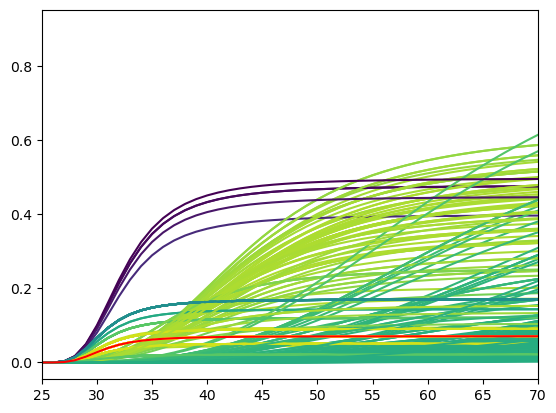

In [23]:
parameter_df = p_space_df['Parameters']
cost_df = p_space_df['Calibration']

n_samples = 300

n_iters = p_space_df.shape[0]
samples = np.random.randint(0, n_iters, size=n_samples)

param_samples = [parameter_df.iloc[i,] for i in samples]
cost_samples = [cost_df.iloc[i,]['Cost Function'] for i in samples]
norm = mpl.colors.LogNorm(vmin=min(cost_samples), vmax=max(cost_samples))
cmap = cm.get_cmap('viridis_r')

_, ax = plt.subplots()
for cost, params in zip(cost_samples, param_samples):
    impf = impf_from_params(params)
    ax.plot(
        np.arange(1,121),
        impf.calc_mdr(np.arange(1,121)),
        color = cmap(norm(cost)),
    )

best_impf = impf_from_params(optimal_params)
ax.plot(
    np.arange(1,121),
    best_impf.calc_mdr(np.arange(1,121)),
    color='red',
)

ax.set_xlim([25, 70])
plt.show()

### Exceedance curves

Next we'll compare modelled return periods curves.

To do this we'll get the optimal model output:

In [24]:
from utils import folder_naming
import hashlib

# TODO make a more user-friendly way to access these

def get_saved_results():
    output_dir = Path(folder_naming.get_direct_output_dir(config_template['run_title'])).parent.parent
    output_folders = os.listdir(output_dir)
    return [pd.read_csv(Path(output_dir, d, 'direct', 'reproduced_obs.csv')) for d in output_folders if d != 'optimisation_output.hdf5']
    

def get_results_from_params(params):
    run_title = config_template['run_title'] + NCCSBayesianOptimizer.hash_params(params)
    direct_output_dir = folder_naming.get_direct_output_dir(run_title)
    results_path = Path(direct_output_dir, 'reproduced_obs.csv')
    return pd.read_csv(results_path)

optimal_df = get_results_from_params(optimal_params)

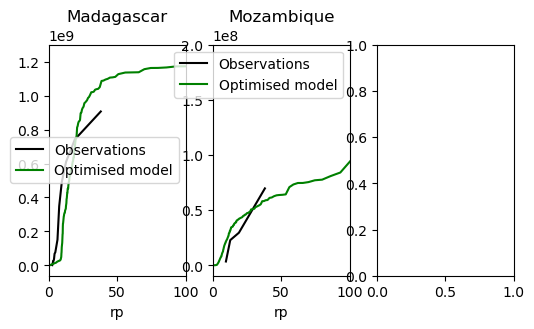

In [25]:
n_plot_rows = int(np.ceil(len(countries) / 3))
_, axs = plt.subplots(ncols=3, nrows=n_plot_rows, figsize=(6, 2*n_plot_rows+1))

for c, ax in zip(countries, axs):
    country = pycountry.countries.get(name=c).alpha_3
    obs[obs['country'] == country].plot(x='rp', y='impact', label='Observations', color='black', title=c, ax=ax)
    optimal_df[optimal_df['country'] == country].plot(x='rp', y='impact', label='Optimised model', color='green', ax=ax)
    ax.set_xlim([0, 100])
plt.show()

And we can look at the range of fits:

In [26]:
parameter_df = p_space_df['Parameters']
cost_df = p_space_df['Calibration']

saved_results = get_saved_results()

2024-10-08 09:01:53,084 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:01:53,192 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:01:53,299 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:01:53,411 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:01:53,518 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:01:53,639 - calibration.interpolate_return_periods - WARNING - The cost calculati

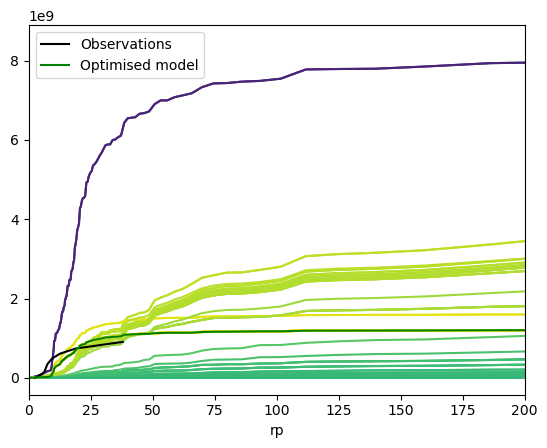

2024-10-08 09:02:06,953 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:02:07,060 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:02:07,164 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:02:07,275 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:02:07,379 - calibration.interpolate_return_periods - WARNING - The cost calculation had missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-08 09:02:07,485 - calibration.interpolate_return_periods - WARNING - The cost calculati

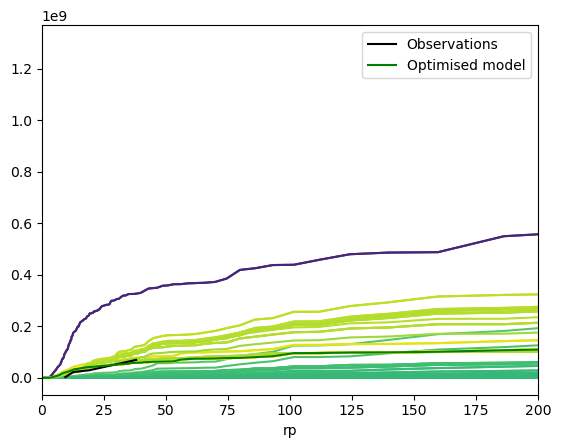

In [27]:
n_iters = len(saved_results)
samples = np.random.randint(0, n_iters, 100)

for c in countries:
    country = pycountry.countries.get(name=c).alpha_3
    fig, ax = plt.subplots()
    for i in samples:
        df = saved_results[i]
        cost = cost_function(obs[['country', 'impact', 'rp']], df[['country', 'impact', 'rp']])
        # print('these results')
        # print(df)
        # print('obs')
        # print(obs)
        df[df['country'] == country].plot(x='rp', y='impact', legend=False, color=cmap(norm(cost)), ax=ax)
        # break
    obs[obs['country'] == country].plot(x='rp', y='impact', label='Observations', color='black', ax=ax)
    optimal_df[optimal_df['country'] == country].plot(x='rp', y='impact', label='Optimised model', color='green', ax=ax)
    ax.set_xlim([0, 200])
    plt.show()

({'scale': 0.07065481368670892, 'v_half': 30.663197174918768}, 145092766.1373064)
({'scale': 0.07065481368670892, 'v_half': 30.663197174918768}, 145092766.1373064)
({'scale': 0.3572714402429018, 'v_half': 41.77994960429743}, 192125809.47687536)
({'scale': 0.07089878557197517, 'v_half': 30.673074168658395}, 145234859.67102912)
({'scale': 0.09419376925608013, 'v_half': 30.66021352969166}, 178252286.38611454)
({'scale': 0.07095335014469836, 'v_half': 30.664970822076892}, 145114742.0680071)
({'scale': 0.07095402503539691, 'v_half': 30.66524404335359}, 145118775.4635008)
({'scale': 0.07095352038800067, 'v_half': 30.665014877995294}, 145115392.68851027)
({'scale': 0.07095137313581941, 'v_half': 30.665616404227833}, 145124259.6448141)
({'scale': 0.09419376925608013, 'v_half': 30.66021352969166}, 178252286.38611454)
({'scale': 0.09419376925608013, 'v_half': 30.66021352969166}, 178252286.38611454)
({'scale': 0.07095373389141382, 'v_half': 30.665061522973993}, 145116081.69421646)
({'scale': 0.07

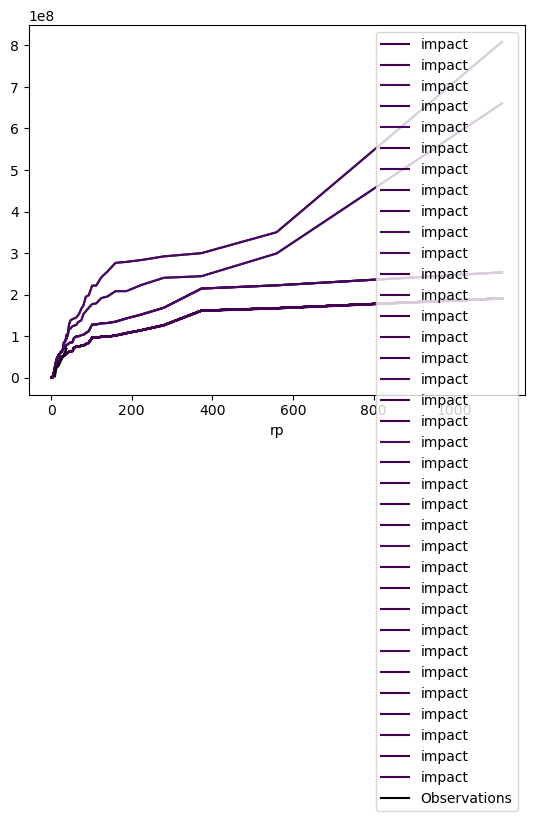

In [30]:
# Testing cost functions...
import matplotlib.cm as cm
from calibration.rp_errors import merge_outputs_and_obs
country = 'MOZ'
fig, ax = plt.subplots()

norm = plt.Normalize(min(cost_df['Cost Function']), max(cost_df['Cost Function']))
cmap = cm.get_cmap('viridis')  # Choose a colormap

for i in samples:
    try:
        params = parameter_df.iloc[i,].to_dict()
        cost = cost_df.iloc[i,].to_dict()['Cost Function']
        df = get_results_from_params(params)
        print((params, cost))
        rps = merge_outputs_and_obs(df, obs)
        colour = cmap(norm(cost))
        df[df['country'] == country].plot(x='rp', y='impact', label=None, color=colour, ax=ax)
    except FileNotFoundError:
        pass

rps[rps['country'] == country].plot(x='rp', y='obs', label='Observations', color='black', ax=ax)
plt.show()


# The optimised impact function

In [32]:
from pipeline.direct.direct import apply_sector_impf_set
from climada.entity import ImpfTropCyclone, ImpactFuncSet

impf_best_guesstimate = apply_sector_impf_set("tropical_cyclone", "economic_assets", countries[0], business_interruption=False, calibrated=False)
impf_best_guesstimate.name = 'Best guesstimate'

def get_impact_function_from_params(params):
    impf = ImpfTropCyclone.from_emanuel_usa(
                scale=params['scale'],
                v_thresh=25.8, # params['v_thresh'],
                v_half=params['v_half']
            )

impf_calibrated = get_impact_function_from_params(optimal_params)
impf_calibrated.name = "Optimal"

impf_set = ImpactFuncSet([impf_best_guesstimate, impf_calibrated])
impf_set.plot()

ValueError: Could not find a unique region for ISO3 code Madagascar. Results: []

The CLIMADA analyses have a nice bit of functionality that lets you explore the range of impact functions and the hazards that went into them. They depend on CLIMADA-specific classes, but we can construct them with the data we've created in this notebook and module.

In [ ]:
from pipeline.direct import get_hazard, get_sector_exposure
from climada.hazard import Hazard
from climada.entity import Exposures
from climada.util.calibrate import Input, Output, BayesianOptimizerOutputEvaluator

haz = Hazard.concat([get_hazard("tropical_cyclone", c, "None", "historical") for c in countries_iso3alpha])
exp = Exposures.concat([get_sector_exposure('economic_assets', c) for c in countries_iso3alpha])

bo_input = Input(
    hazard = haz,
    exposure = exp,
    data = None,
    impact_func_creator = get_impact_function_from_params,
    impact_to_dataframe = None,
    cost_func = None,
    bounds = None,
    constraints = None
    # impact_calc_kwds: Mapping[str, Any] = field(
    #     default_factory=lambda: {"assign_centroids": False}
    # )
    # missing_data_value: float = np.nan
    # assign_centroids: InitVar[bool] = True
)

bo_output = Output(
    params = bayes_output.params,
    target = bayes_output.target,
)


evaluator = BayesianOptimizerOutputEvaluator(
    input = bo_input,
    output = bo_output,
    p_space = opt._space
)

In [ ]:
evaluator.plot_impf_variability()